In [1]:
pip install geneticalgorithm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [3]:
def drawAHU (ahu,clustCenter,oaFrac,path): #Function to draw multiple AHU diagrams as snapshots of operations

    for k in clustCenter.index:

        img = Image.new('RGB', (3600, 1200), (255, 255, 255))
        d = ImageDraw.Draw(img)

        # draw AHU ducts   
        d.line([(600,800),(3000,800)], fill ="black", width = 20)
        d.line([(600,600),(1200,600)], fill ="black", width = 20)
        d.line([(1200,600),(1200,250)], fill ="black", width = 20)
        d.line([(1500,600),(1500,250)], fill ="black", width = 20)
        d.line([(1500,600),(3000,600)], fill ="black", width = 20)

        # draw dampers
        d.line([(1250,550),(1450,400)], fill ="black", width = 12) # return damper
        d.line([(850,750),(950,650)], fill ="black", width = 12) # outdoor damper
        d.line([(900,475),(1350,475)], fill ="black", width = 8)
        d.line([(900,700),(900,475)], fill ="black", width = 8)

        # draw coils/fans
        d.rectangle((1800, 725, 2100, 875), fill=(225, 0, 0)) #heating coil
        d.rectangle((2200, 725, 2500, 875), fill=(0, 0, 225)) #cooling coil
        d.ellipse((2600, 725, 2900, 875), fill=(0, 0, 0)) #supply fan

        # draw arrows
        d.polygon([(600,700), (500, 750), (530,700), (500,650)], fill = 'black') # outdoor arrow
        d.polygon([(1350,250), (1300, 150), (1350,180), (1400,150)], fill = 'black') # return arrow
        d.polygon([(3270,700), (3170, 750), (3200,700), (3170,650)], fill = 'black') # supply arrow

        # Add text
        font = ImageFont.truetype("arial.ttf", 100)
        d.text((1220, 40), "return", font=font, fill='black')
        d.text((1240, 260), str(clustCenter.iloc[k][clustCenter.columns[6]])+" C", font=font, fill='black')#tRa
        d.text((150, 640), "outdoor", font=font, fill='black')
        d.text((620, 640), str(clustCenter.iloc[k][clustCenter.columns[5]])+" C", font=font, fill='black')#tOa
        d.text((2875, 640), "supply", font=font, fill='black')
        d.text((3300, 640), str(clustCenter.iloc[k][clustCenter.columns[7]])+" C", font=font, fill='black')#tSa
        tMa = clustCenter.iloc[k][clustCenter.columns[5]]*min((clustCenter.iloc[k][clustCenter.columns[4]]*oaFrac)/100,1) + clustCenter.iloc[k][clustCenter.columns[6]]*(1-min((clustCenter.iloc[k][clustCenter.columns[4]]*oaFrac)/100,1)) #compute mixed air temperature
        d.text((1500, 640), str(int(round(tMa)))+" C", font=font, fill='black')
        d.text((1790, 860), "heating", font=font, fill='black')
        d.text((1880, 960), "coil", font=font, fill='black')
        d.text((1830, 750), str(clustCenter.iloc[k][clustCenter.columns[3]])+"%", font=font, fill='white')#heating coil
        d.text((2190, 860), "cooling", font=font, fill='black')
        d.text((2280, 960), "coil", font=font, fill='black')
        d.text((2230, 750), str(clustCenter.iloc[k][clustCenter.columns[1]])+"%", font=font, fill='white')#cooling coil
        d.text((2610, 860), "supply", font=font, fill='black')
        d.text((2680, 960), "fan", font=font, fill='black')
        d.text((2630, 750), str(clustCenter.iloc[k][clustCenter.columns[2]])+"%", font=font, fill='white')#supply fan
        d.text((1790, 200), "Fraction of time operation: " + str(clustCenter.iloc[k][clustCenter.columns[8]])+'%', font=font, fill='black')#duration of operation
        d.text((1550, 300), "Fraction with active perimeter heaters: " + str(clustCenter.iloc[k][clustCenter.columns[0]])+'%', font=font, fill='black')#perimeter heaters
        d.text((800,365), str(clustCenter.iloc[k][clustCenter.columns[4]])+'%', font=font, fill='black')#damper
    
        img.save(output_path + r'\f2b_ahu_' + str(ahu+1) + '_C_' + str(k+1) + '.png')

    return 

In [4]:
def ahuAnomaly (all_ahu_data,sRad,tIn,path):
    
    def ahuModes(x): #Dimension = 5
        # x[0] sOa min setpoint
        # x[1] tOa changepoint for mode 1/mode 2
        # x[2] tOa changepoint for mode 2/mode 3
        # x[3] tOa changepoint for mode 3/mode 4
        # x[4] sOa max
        conditions = [tOa <= x[1], (tOa > x[1]) & (tOa <= x[2]), (tOa > x[2]) & (tOa <= x[3]), tOa > x[3]]
        choices = [x[0], (x[4]-x[0])*(tOa-x[1])/(x[2]-x[1]) + x[0], x[4], x[0]]
        sOaPred = np.select(conditions,choices,default=0)

        if ((x[1]>x[2])|(x[2]>x[3])):
            return 100*(np.sqrt(((sOa - sOaPred) ** 2).mean()))
        else:
            return np.sqrt(((sOa - sOaPred) ** 2).mean())
        
    def tSaMdl(x): #Dimension = 4
        # x[0] tSaWtr
        # x[1] tSaSmr
        # x[2] tOaWtr
        # x[3] tOaSmr
        conditions = [tOa <= x[2], (tOa > x[2]) & (tOa <= x[3]), tOa > x[3]]
        choices = [x[0], (x[0]-x[1])/(x[2]-x[3])*(tOa-x[2])+x[0], x[1]]
        tSaPred = np.select(conditions,choices,default=0)

        return np.sqrt(((tSa - tSaPred) ** 2).mean())
    
    def ahuMdlModel_2(x): #Dimension = 3
        # x[0] outdoor air fraction bias
        # x[1] Delta temp across heating coil
        # x[2] Temp bias across ducts
        oaFrac = sOa*x[0]/100
        oaFrac[oaFrac>1] = 1
        tMa = tOa*oaFrac + tRa*(1-oaFrac)
        yp = tMa + sHc*x[1] + x[2]
        
        return np.sqrt(((tSa - yp) ** 2).mean())

    def ahuMdlMode4(x): #Dimension = 2
        # x[0] Delta temp across cooling coil
        # x[1] Temp bias across ducts
        oaFrac = sOa*ahuMdlModel_2_Prmtr[0]/100
        oaFrac[oaFrac>1] = 1
        tMa = tOa*oaFrac + tRa*(1-oaFrac)
        yp = tMa + sCc*x[0] + x[1]
        
        return np.sqrt(((tSa - yp) ** 2).mean())

    sRad = sRad.mean(axis=1)
    tInCld = tIn.quantile(.05, axis=1)
    tInWrm = tIn.quantile(.95, axis=1)
    tInAvg = tIn.mean(axis=1)

    ahuMdl = pd.DataFrame()
    faults_df = pd.DataFrame()
    kfactorInd = 0

    for i in all_ahu_data.index.unique():
        print(str(i))
        data = all_ahu_data.loc[i] #Select only data from AHU i
        data = data.set_index(data.columns[0])
        
        #Drop stagnant data
        mask = data.iloc[:,3].rolling(24).std() < 0.001
        dataNew = data.drop(data[mask].index)
        sRadAvg = sRad.drop(sRad[mask].index)
        tInCldNew = tInCld.drop(tInCld[mask].index)
        tInWrmNew = tInWrm.drop(tInWrm[mask].index)
        tInAvgNew = tInAvg.drop(tInAvg[mask].index)
        
        #Extract only workhours
        mask = ((dataNew.index.hour>8)&(dataNew.index.hour<17)) & (dataNew.index.weekday<5)
        dataWrkHrs = dataNew[mask]
        sRadAvgWrkHrs = sRadAvg[mask]
        tInCldWrkHrs = tInCldNew[mask]
        tInWrmWrkHrs = tInWrmNew[mask]
        tInAvgWrkHrs = tInAvgNew[mask]
        
        #Draw split range controller plot
        tOa = dataWrkHrs[dataWrkHrs.columns[2]]
        sOa = dataWrkHrs[dataWrkHrs.columns[4]]
        if max(sOa)<=1:
            sOa = sOa * 100
        tSa = dataWrkHrs[dataWrkHrs.columns[0]]

        #Optimize parameters for all genetic algorithms
        varbound = np.array([[0,100],[-20,30],[-20,30],[-20,30],[0,100]]) # ([lower_bound,upper_bound])
        algorithm_param = {'max_num_iteration': 20,\
                   'population_size':5000,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':10}
        
        model=ga(function=ahuModes,\
            dimension=5,\
            variable_type='real',\
            variable_boundaries=varbound,\
            algorithm_parameters=algorithm_param)
            
        model.run() #run ahuModes
        cp = model.output_dict['variable']
        
        tOa_range = np.arange(-25.0,35.0,0.1)
        conditions = [tOa_range <= cp[1], (tOa_range > cp[1]) & (tOa_range <= cp[2]), (tOa_range > cp[2]) & (tOa_range <= cp[3]), tOa_range > cp[3]]
        choices = [cp[0], (100-cp[0])*(tOa_range-cp[1])/(cp[2]-cp[1]) + cp[0], 100, cp[0]]
        y = np.select(conditions,choices,default=0)

        #Optimize parameters for genetic algorithms for tSaMdl
        varbound = np.array([[12,20],[12,20],[-20,10],[10,20]]) # ([lower_bound,upper_bound])
        model=ga(function=tSaMdl,\
            dimension=4,\
            variable_type='real',\
            variable_boundaries=varbound,\
            algorithm_parameters=algorithm_param) 
            
        model.run() #Run tSaMdl
        tSaPrmtr = model.output_dict['variable']
        
        conditions = [tOa_range <= tSaPrmtr[2], (tOa_range > tSaPrmtr[2]) & (tOa_range <= tSaPrmtr[3]), tOa_range > tSaPrmtr[3]]
        choices = [tSaPrmtr[0], (tSaPrmtr[0]-tSaPrmtr[1])/(tSaPrmtr[2]-tSaPrmtr[3])*(tOa_range-tSaPrmtr[2])+tSaPrmtr[0], tSaPrmtr[1]]
        tSaPr = np.select(conditions,choices,default=0)

        #Plot first subplot of f2a_ahu_
        fig, ax = plt.subplots(2,figsize=(15,12))
        ax[0].set_xlabel(r'$t_{oa}(C)$', fontsize=30)
        ax[0].set_ylabel(r'$t_{in}(C)$', fontsize=30)
        ax[0].set_xlim(-25,35)
        ax[0].set_ylim(10,30)
        ax[0].set_xticks(np.arange(-25,36,5))
        ax[0].set_yticks(np.arange(12,31,3))
        ax[0].set_xticklabels(np.arange(-25,36,5),fontsize=25)
        ax[0].set_yticklabels(np.arange(12,31,3),fontsize=25)

        a = np.linspace(-25,35,num=100)
        p = np.polyfit(tOa,tInCldWrkHrs,2) #tIn,cld
        ax[0].plot(a,np.polyval(p,a),'b-', linewidth=4, label=r'$t_{in,cld}$')
        p = np.polyfit(tOa,tInAvgWrkHrs,2) #tIn,avg
        ax[0].plot(a,np.polyval(p,a),'k-', linewidth=4, label=r'$t_{in,avg}$')
        p = np.polyfit(tOa,tInWrmWrkHrs,2) #tIn,Wrm
        ax[0].plot(a,np.polyval(p,a),'r-', linewidth=4, label=r'$t_{in,hot}$')
        ax[0].plot(tOa_range,tSaPr,'k--', linewidth=4, label=r'$t_{sa}$')
        ax[0].legend(ncol=4,loc='upper center',prop={"size":24})

        #Plot second subplot f2a_ahu_
        ax[1].set_xlabel(r'$t_{oa}(C)$', fontsize=30)
        ax[1].set_ylabel(r'$s_{oa,hc,cc,rad}$ (%)', fontsize=30)
        ax[1].set_xlim(-25,35)
        ax[1].set_ylim(0,100)
        ax[1].set_xticks(np.arange(-25,36,5))
        ax[1].set_yticks(np.arange(0,101,10))
        ax[1].set_xticklabels(np.arange(-25,36,5),fontsize=25)
        ax[1].set_yticklabels(np.arange(0,101,10),fontsize=25)

        ax[1].plot(tOa_range,y,'k-.',linewidth=4,label=r'$s_{oa}$')

        htgMdInd = tOa <= cp[1]
        sHcHtgMode = dataWrkHrs[dataWrkHrs.columns[5]][htgMdInd]
        tOaHtgMode = tOa[htgMdInd]
        x_train = np.select([tOaHtgMode < cp[1]],[cp[1]-tOaHtgMode],default=0)[np.newaxis].T
        mdl = linear_model.LinearRegression(fit_intercept=False).fit(x_train, sHcHtgMode)
        x_test = np.select([tOa_range < cp[1]],[cp[1]-tOa_range],default=0)[np.newaxis].T
        y = mdl.predict(x_test) #Note y is overwritten
        ax[1].plot(tOa_range,y,'r-',linewidth=4,label=r'$s_{hc}$')

        clgMdInd = tOa > cp[2]
        sCcClgMode = dataWrkHrs[dataWrkHrs.columns[6]][clgMdInd]
        tOaClgMode = tOa[clgMdInd]
        x_train = np.select([tOaClgMode > cp[2]],[cp[2]-tOaClgMode],default=0)[np.newaxis].T
        mdl = linear_model.LinearRegression(fit_intercept=False).fit(x_train, sCcClgMode)
        x_test = np.select([tOa_range > cp[2]],[cp[2]-tOa_range],default=0)[np.newaxis].T
        y = mdl.predict(x_test)
        ax[1].plot(tOa_range,y,'b:',linewidth=4,label=r'$s_{cc}$')

        htgEconMdInd = tOa < cp[2]
        sRadHtgEconMode = sRadAvgWrkHrs[htgEconMdInd]
        tOaHtgEconMode = tOa[htgEconMdInd]
        x_train = np.select([tOaHtgEconMode < cp[2]],[cp[2]-tOaHtgEconMode],default=0)[np.newaxis].T
        mdl = linear_model.LinearRegression().fit(x_train, sRadHtgEconMode)
        x_test = np.select([tOa_range < cp[2]],[cp[2]-tOa_range],default=0)[np.newaxis].T
        y = mdl.predict(x_test)
        y = np.where(tOa_range >= cp[2],0,y)
        y = np.where(y>100,100,y)
        y = np.where(y<0,0,y)
        ax[1].plot(tOa_range,y,'r--',linewidth=4,label=r'$s_{rad}$')

        ax[1].axvspan(-25, cp[1], alpha=0.2, color='r')
        ax[1].axvspan(cp[1], cp[2], alpha=0.2, color='y')
        ax[1].axvspan(cp[2], cp[3], alpha=0.2, color='k')
        ax[1].axvspan(cp[3], 35, alpha=0.2, color='b')
        ax[1].legend(ncol=4,loc='lower center',prop={"size":25},bbox_to_anchor=(0.5,-0.4))

        plt.tight_layout()
        plt.savefig(output_path + r'\f2a_ahu_' + str(kfactorInd+1) + '.png',dpi=600)

        #MULTIPLE LINEAR REGRESSION to extract ahuMdl

        tSa = dataWrkHrs[dataWrkHrs.columns[0]][htgEconMdInd] 
        tRa = dataWrkHrs[dataWrkHrs.columns[1]][htgEconMdInd] 
        tOa = dataWrkHrs[dataWrkHrs.columns[2]][htgEconMdInd] #Note: tOa is redefined here.
        sOa = dataWrkHrs[dataWrkHrs.columns[4]][htgEconMdInd] 
        sHc = dataWrkHrs[dataWrkHrs.columns[5]][htgEconMdInd] 
        tSaSp = dataWrkHrs[dataWrkHrs.columns[8]][htgEconMdInd] 
        tSaErrHtg = (tSa - tSaSp).mean()

        #Optimize parameters for genetic algorithms for ahuMdlModel_2
        varbound = np.array([[0.1,1.5],[0,0.5],[-1,1]]) # ([lower_bound,upper_bound])
        
        #Same parameters as tSaMdl
        model=ga(function=ahuMdlModel_2,\
            dimension=3,\
            variable_type='real',\
            variable_boundaries=varbound,\
            algorithm_parameters=algorithm_param)
            
        model.run() #Run ahuMdlModel_2
        ahuMdlModel_2_Prmtr = model.output_dict['variable']
        
        clgMdInd = dataWrkHrs[dataWrkHrs.columns[2]] > cp[3]
        tSa = dataWrkHrs[dataWrkHrs.columns[0]][clgMdInd] 
        tRa = dataWrkHrs[dataWrkHrs.columns[1]][clgMdInd] 
        tOa = dataWrkHrs[dataWrkHrs.columns[2]][clgMdInd] #Note: tOa is redefined here.
        sOa = dataWrkHrs[dataWrkHrs.columns[4]][clgMdInd] 
        sCc = dataWrkHrs[dataWrkHrs.columns[6]][clgMdInd] 
        tSaSp = dataWrkHrs[dataWrkHrs.columns[8]][clgMdInd] 
        tSaErrClg = (tSa - tSaSp).mean()

        #Optimize parameters for genetic algorithms for ahuMdlMode4
        varbound = np.array([[-0.5,0],[-1,1]]) # ([lower_bound,upper_bound])
        
        #Same parameters as tSaMdl and ahuMdlModel_2
        model=ga(function=ahuMdlMode4,\
            dimension=2,\
            variable_type='real',\
            variable_boundaries=varbound,\
            algorithm_parameters=algorithm_param)
        
        model.run() #Run ahuMdlMode4
        ahuMdlMode4_Prmtr = model.output_dict['variable']

        #Save variables from ahuMdlModel_2 and ahuMdlMode4 in ahuMdl Dataframe
        ahuMdl = ahuMdl.append({'oaFrac':ahuMdlModel_2_Prmtr[0],'dtHc':ahuMdlModel_2_Prmtr[1]*100, 'dtCc':ahuMdlMode4_Prmtr[0]*100}, ignore_index=True)
        

        #Cluster operations into groups and snapshot operation
        ahuOperationDuration = sum(dataNew[dataNew.columns[7]]>0)/len(dataNew.index)*168
        print(ahuOperationDuration)
        mask = dataNew.iloc[:,7] > 0
        clusterFrame = pd.DataFrame()
        clusterFrame = pd.concat([dataNew[mask][dataNew.columns[0:3]], dataNew[mask][dataNew.columns[4:8]], sRadAvg[mask]], axis=1, sort=False)
        
        normData = clusterFrame / np.linalg.norm(clusterFrame)
        pca = PCA()
        pca.fit(normData)
        scores_array = pca.fit_transform(normData)
        scores = pd.DataFrame(data=scores_array)
        explained = pca.explained_variance_ratio_
        features = scores[scores.columns[0:1+min(min(np.where(np.cumsum(explained)>0.95)))]]

        best_score = 0
        for n in range(4,7): # loop through 4 to 6 clusters
            evaKMeans = cluster.KMeans(n_clusters=n,random_state=1).fit_predict(features) #Create cluster labels
            kmeans_score = metrics.calinski_harabasz_score(features, evaKMeans) # Score cluster labels

            evaGMdist = mixture.GaussianMixture(n_components=n,covariance_type='full').fit_predict(features)
            gmm_score = metrics.calinski_harabasz_score(features, evaGMdist)
        
            evaLinkage = cluster.AgglomerativeClustering(n_clusters=n).fit_predict(features)
            link_score = metrics.calinski_harabasz_score(features, evaLinkage)

            #Find best clustering method and take k-clusters
            if kmeans_score > best_score:
                best_score = kmeans_score
                eva = evaKMeans
                optimalK = n
            if gmm_score > best_score:
                best_score = gmm_score
                eva = evaGMdist
                optimalK = n
            if link_score > best_score:
                best_score = link_score
                eva = evaLinkage
                optimalK = n

        clusterCenter = pd.DataFrame()
        clusterSize = []
        
        for j in range (0,optimalK):
            clusterCenter = clusterCenter.append((round(clusterFrame[eva==j].median(axis=0))), ignore_index=True)
            clusterSize.append(round(sum(eva==j)/len(eva),2)*100)
        
        clusterCenter['size'] = clusterSize # Merge clusterSize with clusterCenter
        clusterCenter = clusterCenter.sort_values(by=clusterCenter.columns[5]).astype('int64') #sort by ascending tOa
     
        drawAHU(kfactorInd,clusterCenter,ahuMdlModel_2_Prmtr[0],path) # Pass to function to draw AHUs


        #COMPUTE FAULTS
        ahuHealthInd = 0
        if ahuMdlModel_2_Prmtr[0] < 0.5:
            sOa_fault = 'Low outdoor air'
        elif ahuMdlModel_2_Prmtr[0] > 1.3:
            sOa_fault = 'High outdoor air'
        else:
            sOa_fault = 'Normal'
            ahuHealthInd += 100/6
        
        if ahuMdlModel_2_Prmtr[1]*100 < 1.0:
            sHc_fault = 'Stuck'
        else:
            sHc_fault = 'Normal'
            ahuHealthInd += 100/6
        
        if ahuMdlMode4_Prmtr[0]*100 > -1.0:
            sCc_fault = 'Stuck'
        else:
            sCc_fault = 'Normal'
            ahuHealthInd += 100/6
        
        fracRadOnEconomizer = sRadAvgWrkHrs[((dataWrkHrs[dataWrkHrs.columns[2]] > cp[1]) | (dataWrkHrs[dataWrkHrs.columns[2]] < cp[2]))].mean()
        tInWrmEcon = tInWrmWrkHrs[((dataWrkHrs[dataWrkHrs.columns[2]] > cp[1]) | (dataWrkHrs[dataWrkHrs.columns[2]] < cp[2]))].mean() #Check for overheating
        
        if (fracRadOnEconomizer > 50) & (cp[1]<-5):
            sRadInEcon_fault = 'Add a low limit to the economizer mode availability'
        elif (fracRadOnEconomizer > 50) & (tInWrmEcon < 24):
            sRadInEcon_fault = 'increase supply air temperature setpoint'
        else:
            sRadInEcon_fault = 'Normal'
            ahuHealthInd += 100/6
        
        if ahuOperationDuration > 112:
            noSchedule_fault = 'No schedule'
        else:
            noSchedule_fault = 'Normal'
            ahuHealthInd += 100/6
        
        if (cp[4]-cp[0])/cp[0] < 0.5:
            noEcon_fault = 'No Economizer'
        else:
            noEcon_fault = 'Normal'
            ahuHealthInd += 100/6
        
        #Save faults in faults_df
        faults_df = faults_df.append({'Outdoor Air Damper':sOa_fault,'Heating Coil':sHc_fault,'Cooling coil':sCc_fault,'Perimeter heating in Econ Mode':sRadInEcon_fault,'Schedule':noSchedule_fault,'Economizer':noEcon_fault,'AHU Health Index':ahuHealthInd}, ignore_index=True)

        kfactorInd += 1 #Plus 1 kFactorInd per AHU loop

    return ahuMdl,faults_df

Number of AHUs detected = 2
Number of Zones detected = 42
ahu1.csv
 The best solution found:
 [37.91957074 -6.13209595 11.77639565 20.95307382 95.4238938 ]

 Objective function:
 15.48318753999314


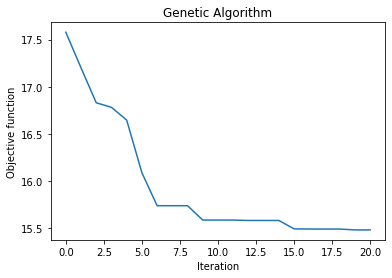

 The best solution found:
 [16.32326394 15.50767725 -1.77824945 10.03014714]

 Objective function:
 1.843656374687018


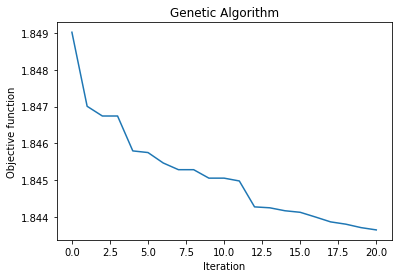

 The best solution found:
 [ 0.41078927  0.02427529 -0.99990177]

 Objective function:
 1.391002070532147


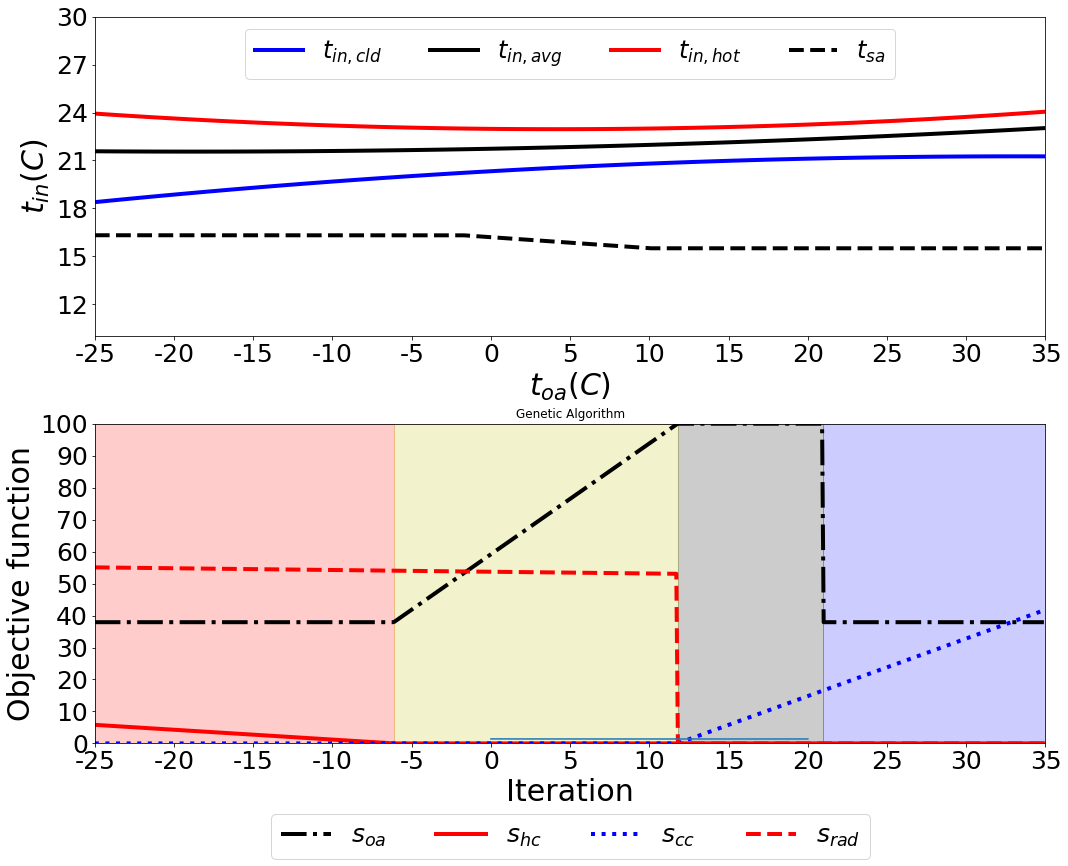

 The best solution found:
 [-0.15709256 -0.99978872]

 Objective function:
 5.096759345445368


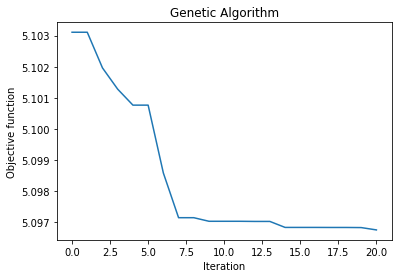

100.24049828397101
ahu2.csv
 The best solution found:
 [31.00219295 -6.77651308 11.79080855 21.47696473 93.1684317 ]

 Objective function:
 20.72145771564054


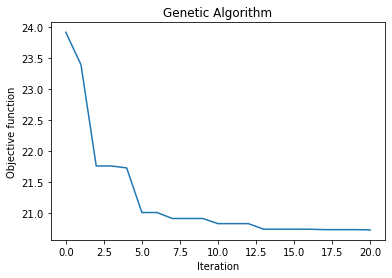

 The best solution found:
 [ 19.98724392  16.50076305 -15.92422893  10.02406669]

 Objective function:
 2.9653118821313798


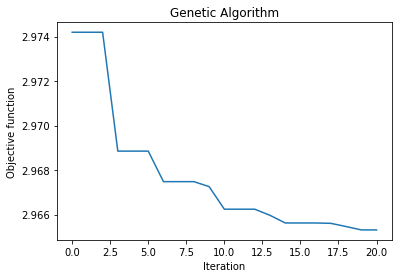

 The best solution found:
 [ 0.23710485  0.03845911 -0.99503306]

 Objective function:
 4.423021722007162


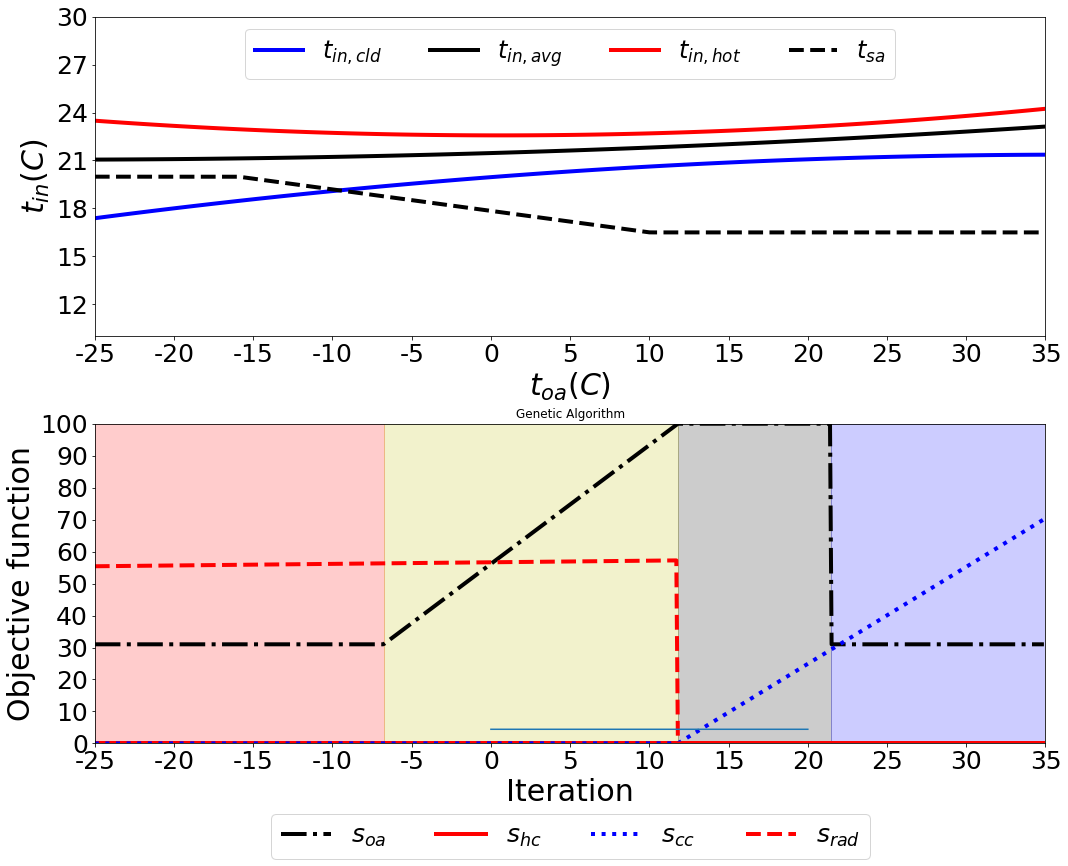

 The best solution found:
 [-0.1198381  -0.99972777]

 Objective function:
 2.7231247809724204


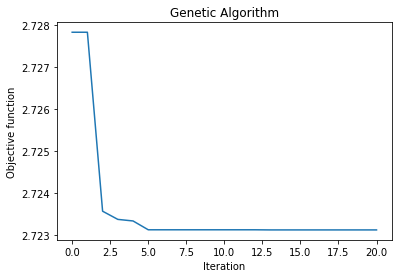

113.0298616168973


In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import linear_model, cluster,preprocessing,metrics,mixture
from sklearn.decomposition import PCA
from geneticalgorithm import geneticalgorithm as ga
from PIL import Image, ImageDraw, ImageFont
import math

#Specify current directory and input/output paths
path = os.getcwd() #Get current directory
ahu_input_path = path + r'\sample data\ahu'
zone_input_path = path + r'\sample data\zone'
output_path = path + r'\output'

#Collect AHU data
ahu_files = os.listdir(ahu_input_path) #Specify the input directory for ahu files
ahu_files_csv = [f for f in ahu_files if f[-3:] == 'csv'] #Get names of excel files for ahu files
dfs = []
for f in ahu_files_csv:
    data = pd.read_csv(ahu_input_path + '\\' + f) #Specify the sample data for ahu files
    data = data.rename(columns={data.columns[1]:'tSa',data.columns[2]:'tRa',data.columns[3]:'tOa',data.columns[4]:'pSa',data.columns[5]:'sOa',data.columns[6]:'sHc',data.columns[7]:'sCc',data.columns[8]:'sFan',data.columns[9]:'tSaSp',data.columns[10]:'pSaSp'})
    dfs.append(data)
ahu = pd.concat(dfs,keys=ahu_files_csv).reset_index(level=1, drop=True)
ahu[ahu.columns[0]] = pd.to_datetime(ahu[ahu.columns[0]])

#Collect zone data
zone_files = os.listdir(zone_input_path)#Specify the input directory for zone files
zone_files_csv = [f for f in zone_files if f[-3:] == 'csv']#Get names of excel files for zone files
tIn = pd.DataFrame()
sRad = pd.DataFrame()
for f in zone_files_csv:
    data = pd.read_csv(zone_input_path + '\\' + f, index_col=0) #Specify the sample data and sheet name for zones
    data = data.rename(columns={data.columns[0]:'tIn',data.columns[1]:'qFlo',data.columns[2]:'qFloSp',data.columns[3]:'sRad'})
    tIn = pd.concat([tIn,data[data.columns[0]]], axis=1,sort=False).rename(columns={data.columns[0]:str(f).replace('.csv','')})
    sRad = pd.concat([sRad,data[data.columns[3]]], axis=1,sort=False).rename(columns={data.columns[3]:str(f).replace('.csv','')})
for df in [tIn,sRad]:
    df.index = pd.to_datetime(df.index)

print("Number of AHUs detected = " + str(len(dfs)))
print("Number of Zones detected = " + str(len(tIn.columns)))

ahuMdl, faults = ahuAnomaly(ahu,sRad,tIn,path) #Call ahuAnomaly local function

writer = pd.ExcelWriter(output_path + r'\ahu_anomaly_summary.xlsx', engine='xlsxwriter')
ahuMdl.to_excel(writer, sheet_name='ahuMdl')
faults.to_excel(writer, sheet_name='faults')
writer.save()
